In [3]:
import sys
sys.path.append("../")

<center> This notebook allows us to present our results to real life application </center> 

In [4]:
import numpy as np
import matplotlib.pyplot as plt 

#From src
from SDE.utils.matrix import Matrix
import SDE.utils.yfinance_functions as yf
from SDE.pricer import PricingConfiguration, Option

from SDE.basket import Weighted_Basket
from SDE.bs import BS_Asset

# <center> Build portfolio using real parameters </center> 

In [5]:
my_portfolio_tickers = ['AAPL', 'AMZN', 'TSLA']     # yahoo finance tickers of assets we want
my_exposures = np.array([1/3,1/3,1/3])              # weights corresponding to exposure on each asset's PERFORMANCE (=> to be divided by stocks)

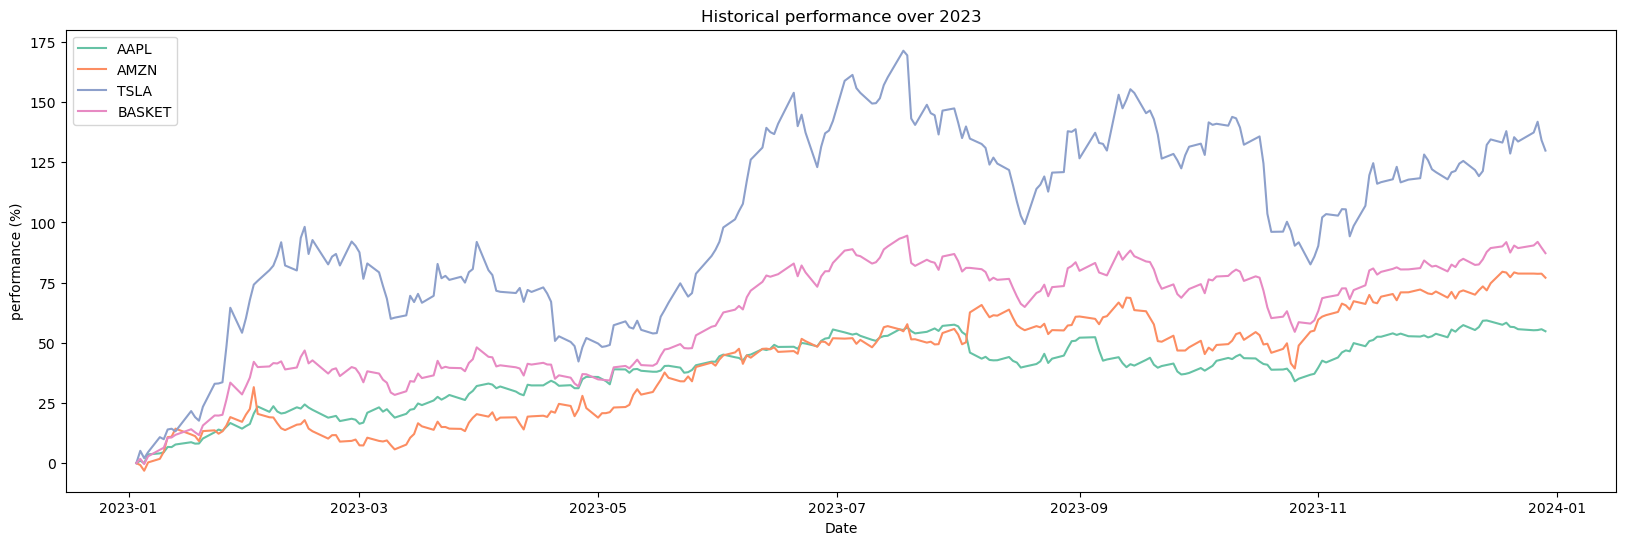

******* TODAY VALUES *******
                                 AAPL   AMZN        TSLA
Date                                                    
2024-05-01 00:00:00-04:00  169.300003  179.0  179.990005
******* 2023 ANNUAL VOL *******
AAPL    0.199543
AMZN    0.330267
TSLA    0.526488
dtype: float64
***** 2023 ANNUAL CORREL ******
          AAPL      AMZN      TSLA
AAPL  1.000000  0.884748  0.827503
AMZN  0.884748  1.000000  0.793269
TSLA  0.827503  0.793269  1.000000
*** REAL WEIGHTS TO GET TARGETED EXPOSURE ****
                               AAPL     AMZN      TSLA
Date                                                  
2024-05-01 00:00:00-04:00  0.196889  0.18622  0.185195


In [6]:
ticker_symbols = my_portfolio_tickers       # List of ticker symbols
start_date = '2023-01-01'                   # Start date
end_date = '2024-01-01'                     # End date
today_date = '2024-05-01'                   # Date at which we set the values

historical_data = yf.get_historical_data(ticker_symbols, start_date, end_date)
today_data = yf.get_date_data(ticker_symbols, today_date)

##### COMPUTE ANNUAL PERFORMANCE ####
historical_perf_start_of_year = (historical_data/historical_data.iloc[0]-1)*100
historical_perf_start_of_year["BASKET"] = np.dot(historical_perf_start_of_year,my_exposures)

##### ANNUAL TRACK #####
yf.plot_stock_curves(historical_perf_start_of_year,"Historical performance over 2023",ylabel="performance (%)")

##### TODAY SPOT #####
print("******* TODAY VALUES *******")
print(today_data)

##### ANNUAL VOL #####
print("******* 2023 ANNUAL VOL *******")
print(yf.compute_annual_volatility(historical_data))

### ANNUAL CORREL ###
print("***** 2023 ANNUAL CORREL ******")
print(yf.compute_correlation_matrix(historical_data))

### WEIGHTS TARGETED ###
print("*** REAL WEIGHTS TO GET TARGETED EXPOSURE ****")
print(100*my_exposures/today_data)

# <center> Build basket </center> 

<center> 
In this section, we build the basket corresponding to an equi-weighted basket between the three assets found above  </br>
The basket is made such that we are exposed equally on the performance on each asset adn initial spot of basket = 200.
</center> 

In [9]:
risk_free_rate = 0.05

# taking real life parameters found above
asset_AAPL = BS_Asset(169.300003,0.20,risk_free_rate)
asset_AMZN = BS_Asset(179,0.32,risk_free_rate)
asset_TSLA = BS_Asset(179.99,0.53,risk_free_rate)
correl_matrix = [[1.000000, 0.884748, 0.827503], [0.884748, 1.000000, 0.793269], [0.827503, 0.793269, 1.000000]]

adjusted_weights = [2*0.196889,2*0.18622,2*0.185195]
my_basket_object = Weighted_Basket(adjusted_weights,[asset_AAPL,asset_AMZN,asset_TSLA],Matrix(correl_matrix),live_seed=True) # better to set live to true to significatively to not introduce bad seed biais

print(f"Inital spot of my basket: {round(my_basket_object.initial_spot,2)}")

Inital spot of my basket: 200.0


# <center> Pricing </center> 
</br>
<center>
This is an introductive session to what can be done in pricing.
</br>
To see more content about variance reduction techniques please take a look at <b>mcls_variance_reduction_results.ipynb</b> and <b>variance_reduction_results.ipynb</b>

<center>

In [10]:
call_option_object = Option(
            strike = 200,
            #terminal_payoff_function=lambda x: max(x-200,0), # not required for call or put but can be set to whatever
            actualisation_rate= 0.05,
            maturity= 1,
            payoff_name= "call"     # allows not to give payoff but not mandatory
            )

### EXEMPLE OF PRICING USING CLOSED FORM FORMULA ###
# pricing_model_name = "CF" is set by default when not providing pricing config
#

print(f"CF European price is: {call_option_object.Price(asset_AAPL)} \n")

### EXEMPLE OF PRICING USING PRE DEFINED REDUCTION TECHNIQUE FOR MC ###
#
#

pricing_config = PricingConfiguration(nb_simulations=10000,pricing_model_name="MC")
call_option_object.set_pricing_configuration(pricing_config)
print(f"MC European price is: {call_option_object.Price(asset_AAPL)} \n")

### EXEMPLE OF PRICING USING PRE DEFINED REDUCTION TECHNIQUE FOR MC ###

pricing_config = PricingConfiguration(nb_simulations=1000000,pricing_model_name="MCLS")
call_option_object.set_pricing_configuration(pricing_config)
print(f"MCLS European price is: {call_option_object.Price(asset_AAPL)} \n")

### EXEMPLE OF PRICING USING PRE DEFINED REDUCTION TECHNIQUE FOR MC ###
pricing_config = PricingConfiguration(nb_simulations=1000000,pricing_model_name="MC")
call_option_object.set_pricing_configuration(pricing_config)
call_option_object.set_predefined_pricing_reduction_techniques(asset_AAPL)
call_option_object.set_pricing_antithetic()
print(f"MC European price is: {call_option_object.Price(asset_AAPL,display_info=True)} \n")


CF European price is: 6.204497101744018 

MC European price is: 6.068770822593438 

MCLS European price is: 6.185963507264666 

**  Antithetic var. set for pricing  european call on <class 'SDE.bs.BS_Asset'> **
  No control var. found for pricing  european call on <class 'SDE.bs.BS_Asset'> object 

            =========================== RESULTS ==========================
                            result : 6.204524304907149
                       option name : call
                     exercise type : european
                     pricing model : MC
             number of simulations : 1000000 (Applicable)
                        antithetic : True (Applicable)
                   control variate : None (Applicable)
                      quasi random : False (Applicable)
            
MC European price is: 6.204524304907149 

